In [9]:
import zipfile
z=zipfile.ZipFile("archive (8).zip")
z.extractall()

In [3]:
import os,shutil
import cv2
import skimage
import skimage.segmentation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')


In [4]:
import os
import cv2
import numpy as np

labels = ['PNEUMONIA', 'NORMAL']
img_size = 128

def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(f"Error loading image {img}: {e}")
    # Separating features and labels
    images, classes = zip(*data)
    return np.array(images), np.array(classes)

train_images, train_labels = get_data("chest_xray/chest_xray/train")
test_images, test_labels = get_data("chest_xray/chest_xray/test")
val_images, val_labels = get_data("chest_xray/chest_xray/val")


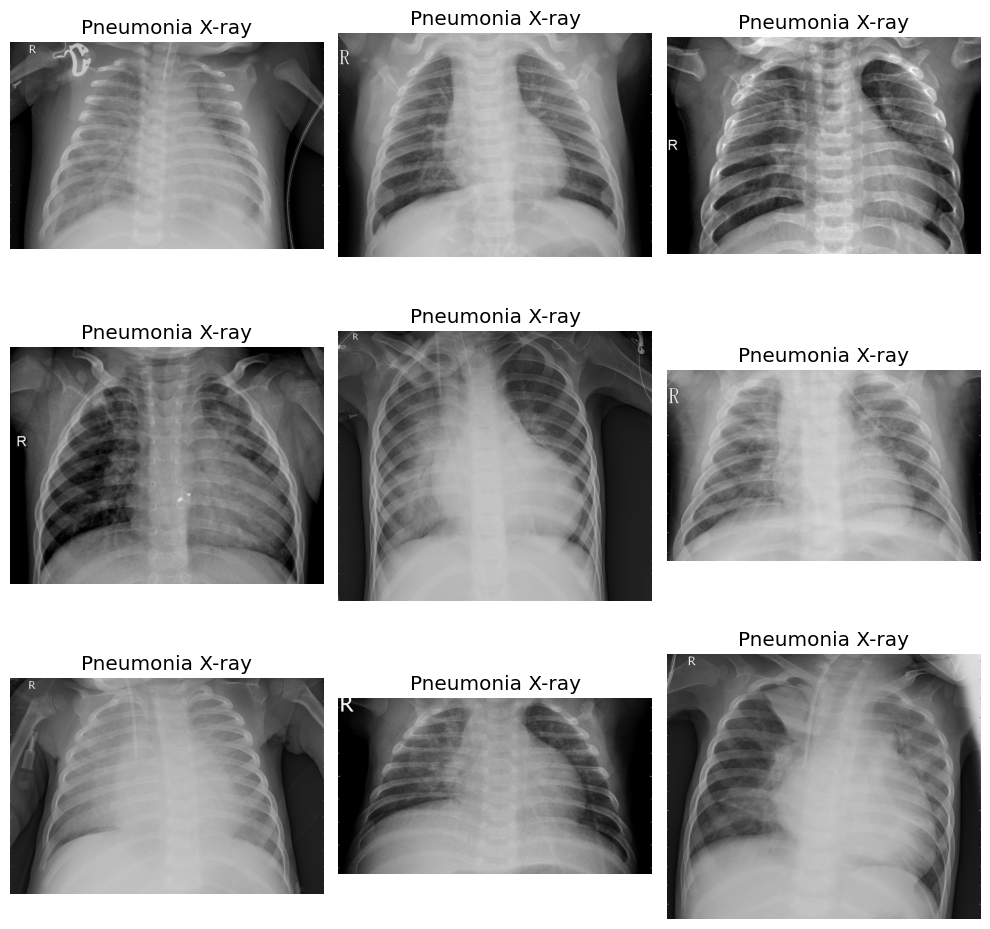

In [5]:
pneumonia_dir = "chest_xray/chest_xray/train/PNEUMONIA"  
pneumonia = os.listdir(pneumonia_dir)

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img_path = os.path.join(pneumonia_dir, pneumonia[i])
    try:
        img = plt.imread(img_path)
        plt.imshow(img, cmap='gray')
        plt.title("Pneumonia X-ray")
        plt.axis('off')  
    except Exception as e:
        print(f"Error reading image {img_path}: {e}")
plt.tight_layout()
plt.show()


In [6]:
normal=os.listdir("chest_xray/train/NORMAL")
normal_dir="chest_xray/train/NORMAL"


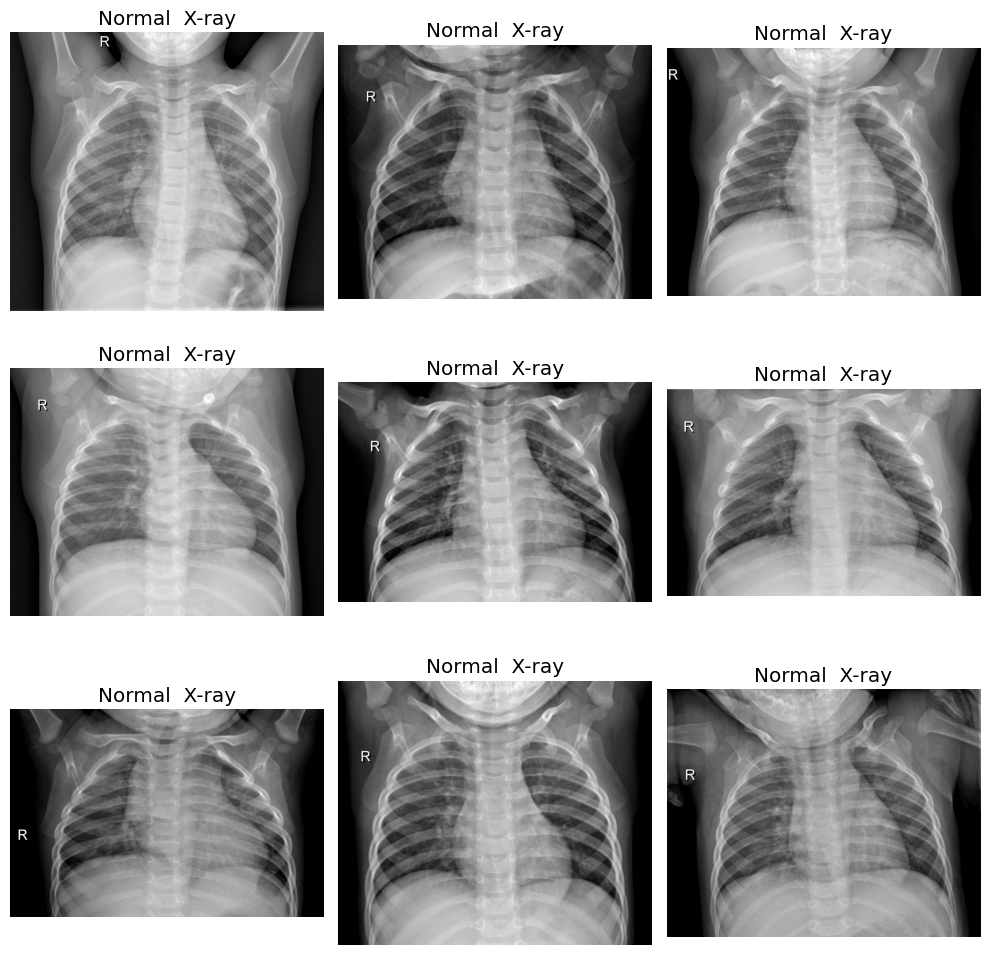

In [7]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img_path = os.path.join(normal_dir, normal[i])
    try:
        img = plt.imread(img_path)
        plt.imshow(img, cmap='gray')
        plt.title("Normal  X-ray")
        plt.axis('off')  
    except Exception as e:
        print(f"Error reading image {img_path}: {e}")
plt.tight_layout()
plt.show()


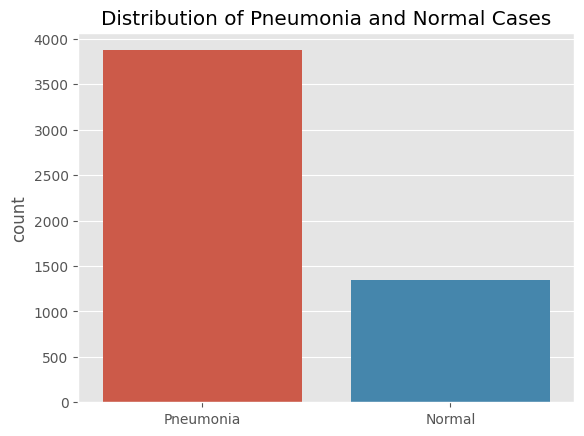

In [8]:
import seaborn as sns

list_count = []
for label in train_labels:
    if label == 0:
        list_count.append("Pneumonia")
    else:
        list_count.append("Normal")

sns.countplot(x=list_count)
plt.title("Distribution of Pneumonia and Normal Cases")
plt.show()


In [9]:
import tensorflow as tf  
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input,Dense,Flatten,Conv2D,Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD,RMSprop,Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau


In [10]:
train_data_gen=ImageDataGenerator(rescale=1. /255,
                                  horizontal_flip=0.5,
                                  vertical_flip=0.5,
                                  rotation_range=60,
                                  shear_range=0.2,
                                  width_shift_range=0.4,
                                  height_shift_range=0.4,
                                  fill_mode="nearest")
valid_data_gen=ImageDataGenerator(rescale= 1. / 255)
test_data_gen=ImageDataGenerator(rescale= 1. / 255)

In [11]:
train_generator=train_data_gen.flow_from_directory("chest_xray/chest_xray/train",
                                                   batch_size=32,
                                                   target_size=(128,128),
                                                   class_mode='categorical',
                                                   shuffle=True,
                                                   seed=42,
                                                   color_mode= 'rgb')

valid_generator=valid_data_gen.flow_from_directory("chest_xray/chest_xray/val",
                                                   batch_size=32,
                                                   target_size=(128,128),
                                                   class_mode='categorical',
                                                   shuffle=True,
                                                   seed=42,
                                                   color_mode= 'rgb')



Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [12]:
class_labels=train_generator.class_indices
class_labels

{'NORMAL': 0, 'PNEUMONIA': 1}

In [13]:
class_name={ value:key for (key,value) in class_labels.items()}
class_name

{0: 'NORMAL', 1: 'PNEUMONIA'}

In [14]:
 test_generator = test_data_gen.flow_from_directory(
    "chest_xray/chest_xray/test",
    batch_size = 32,
    target_size=(128, 128),
    class_mode = 'categorical',
    shuffle=True,
    seed = 42,
    color_mode = 'rgb'
)

Found 624 images belonging to 2 classes.


In [15]:
base_model = VGG19(input_shape = (128,128,3),
                     include_top = False,
                     weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
flat = Flatten()(x)


class_1 = Dense(4608, activation = 'relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(dropout)
output = Dense(2, activation = 'softmax')(class_2)

model_01 = Model(base_model.inputs, output)
model_01.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 63,089,602 (240.67 MB)

 Trainable params: 43,065,218 (164.28 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [17]:
filepath = "model.keras"
es = EarlyStopping(monitor="val_loss", verbose=1, mode="min", patience=4)
cp=ModelCheckpoint(filepath, monitor="val_loss", save_best_only=True, save_weights_only=False,mode="auto", save_freq="epoch")
lrr = ReduceLROnPlateau(monitor="val_accuracy", patience=3, verbose=1, factor=0.5, min_lr=0.0001)

sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum=0.0, nesterov = True)

model_01.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

In [18]:
history_01 = model_01.fit(train_generator, 
            steps_per_epoch=50,
            epochs=5, 
            callbacks=[es, cp, lrr],
            validation_data=valid_generator)

Epoch 1/5


C:\Users\Prit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.6791 - loss: 0.6021 - val_accuracy: 0.5000 - val_loss: 0.8430 - learning_rate: 1.0000e-04
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.7347 - loss: 0.5733 - val_accuracy: 0.5000 - val_loss: 0.8089 - learning_rate: 1.0000e-04
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.7298 - loss: 0.5794 - val_accuracy: 0.5000 - val_loss: 0.7743 - learning_rate: 1.0000e-04
Epoch 4/5
13/50 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.7782 - loss: 0.5383

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 320ms/step - accuracy: 0.7769 - loss: 0.5340 - val_accuracy: 0.5000 - val_loss: 0.8063 - learning_rate: 1.0000e-04
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.7457 - loss: 0.5385 - val_accuracy: 0.5000 - val_loss: 0.7712 - learning_rate: 1.0000e-04


In [13]:
model_01.save("Model/vgg19_model_01.keras")


In [19]:
model_01.load_weights("Model/vgg19_model_01.keras")
vgg_val_eval_01 = model_01.evaluate(valid_generator)
vgg_test_eval_01 = model_01.evaluate(test_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5000 - loss: 0.8022
20/20 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.6141 - loss: 0.6499


In [20]:
print(f"Validation Loss: {vgg_val_eval_01[0]}")
print(f"Validation Accuarcy: {vgg_val_eval_01[1]}")
print(f"Test Loss: {vgg_test_eval_01[0]}")
print(f"Test Accuarcy: {vgg_test_eval_01[1]}")

Validation Loss: 0.8021900057792664
Validation Accuarcy: 0.5
Test Loss: 0.636271595954895
Test Accuarcy: 0.625


In [21]:
base_model = VGG19(include_top=False, input_shape=(128,128,3))
base_model_layer_names = [layer.name for layer in base_model.layers]

x = base_model.output
flat = Flatten()(x)


class_1 = Dense(4608, activation = 'relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(dropout)
output = Dense(2, activation = 'softmax')(class_2)

model_02 = Model(base_model.inputs, output)
model_02.load_weights("Model/vgg19_model_01.keras")

set_trainable = False
for layer in base_model.layers:
    if layer.name in [ 'block5_conv3','block5_conv4']:
        set_trainable=True
    if set_trainable:
        set_trainable=True
    else:
        set_trainable=False
print(model_02.summary())

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 63,089,602 (240.67 MB)

 Trainable params: 63,089,602 (240.67 MB)

 Non-trainable params: 0 (0.00 B)

None


In [22]:
base_model_layer_names

['input_layer_1',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool']

In [23]:
sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum=0.0, nesterov = True)

model_02.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

In [24]:
history_02 = model_02.fit(train_generator, 
            steps_per_epoch=10,
            epochs=5, 
            callbacks=[es, cp, lrr],
            validation_data=valid_generator)

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 73s 7s/step - accuracy: 0.7221 - loss: 0.5712 - val_accuracy: 0.5000 - val_loss: 0.7910 - learning_rate: 1.0000e-04
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 70s 7s/step - accuracy: 0.7614 - loss: 0.5186 - val_accuracy: 0.5000 - val_loss: 0.7677 - learning_rate: 1.0000e-04
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 70s 7s/step - accuracy: 0.7723 - loss: 0.5192 - val_accuracy: 0.5000 - val_loss: 0.7552 - learning_rate: 1.0000e-04
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 70s 7s/step - accuracy: 0.7272 - loss: 0.5382 - val_accuracy: 0.5000 - val_loss: 0.7344 - learning_rate: 1.0000e-04
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 68s 7s/step - accuracy: 0.7691 - loss: 0.5108 - val_accuracy: 0.5000 - val_loss: 0.7782 - learning_rate: 1.0000e-04


In [24]:
model_02.save(filepath = "Model/vgg19_model_02.keras")

In [25]:
model_02.load_weights("Model/vgg19_model_02.keras")

vgg_val_eval_02 = model_02.evaluate(valid_generator)
vgg_test_eval_02 = model_02.evaluate(test_generator)

print(f"Validation Loss: {vgg_val_eval_02[0]}")
print(f"Validation Accuarcy: {vgg_val_eval_02[1]}")
print(f"Test Loss: {vgg_test_eval_02[0]}")
print(f"Test Accuarcy: {vgg_test_eval_02[1]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5000 - loss: 0.7624
20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.6158 - loss: 0.6079
Validation Loss: 0.7623767852783203
Validation Accuarcy: 0.5
Test Loss: 0.6120378375053406
Test Accuarcy: 0.625


In [26]:
base_model = VGG19(include_top=False, input_shape=(128,128,3))

x = base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(dropout)
output = Dense(2, activation = 'softmax')(class_2)

model_03 = Model(base_model.inputs, output)
model_03.load_weights("Model/vgg19_model_01.keras")

print(model_03.summary())

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 63,089,602 (240.67 MB)

 Trainable params: 63,089,602 (240.67 MB)

 Non-trainable params: 0 (0.00 B)

None


In [27]:
sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum=0.0, nesterov = True)

model_03.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

In [28]:
history_03 = model_02.fit(train_generator, 
            steps_per_epoch=100,
            epochs=20, 
            callbacks=[es, cp, lrr],
            validation_data=valid_generator)

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 503s 5s/step - accuracy: 0.7617 - loss: 0.5022 - val_accuracy: 0.5000 - val_loss: 0.6873 - learning_rate: 1.0000e-04
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 295s 3s/step - accuracy: 0.7512 - loss: 0.4936 - val_accuracy: 0.5625 - val_loss: 0.6646 - learning_rate: 1.0000e-04
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 481s 5s/step - accuracy: 0.7812 - loss: 0.4623 - val_accuracy: 0.7500 - val_loss: 0.5712 - learning_rate: 1.0000e-04
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 294s 3s/step - accuracy: 0.7949 - loss: 0.4261 - val_accuracy: 0.6250 - val_loss: 0.5796 - learning_rate: 1.0000e-04
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 468s 5s/step - accuracy: 0.8122 - loss: 0.4043 - val_accuracy: 0.6250 - val_loss: 0.6037 - learning_rate: 1.0000e-04
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 295s 3s/step - accuracy: 0.8398 - loss: 0.3493 - val_accuracy: 0.7500 - val_loss: 0.5408 - learning_rate: 1.0000e-04
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 472s 5s/step - acc

In [1]:
history_03 = model_02.fit(train_generator, 
            steps_per_epoch=100,
            epochs=20, 
            callbacks=[es, cp, lrr],
            validation_data=valid_generator)

NameError: name 'model_02' is not defined

In [29]:
model_03.save(filepath = "Model/vgg19_model_03.keras")

In [32]:
model_03.load_weights("Model/vgg19_model_03.keras")

vgg_val_eval_03 = model_03.evaluate(valid_generator)
vgg_test_eval_03 = model_03.evaluate(test_generator)

print(f"Validation Loss: {vgg_val_eval_03[0]}")
print(f"Validation Accuarcy: {vgg_val_eval_03[1]}")
print(f"Test Loss: {vgg_test_eval_03[0]}")
print(f"Test Accuarcy: {vgg_test_eval_03[1]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step - accuracy: 0.5000 - loss: 0.8022
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6420 - loss: 0.6214
Validation Loss: 0.8021900057792664
Validation Accuarcy: 0.5
Test Loss: 0.6362714767456055
Test Accuarcy: 0.625


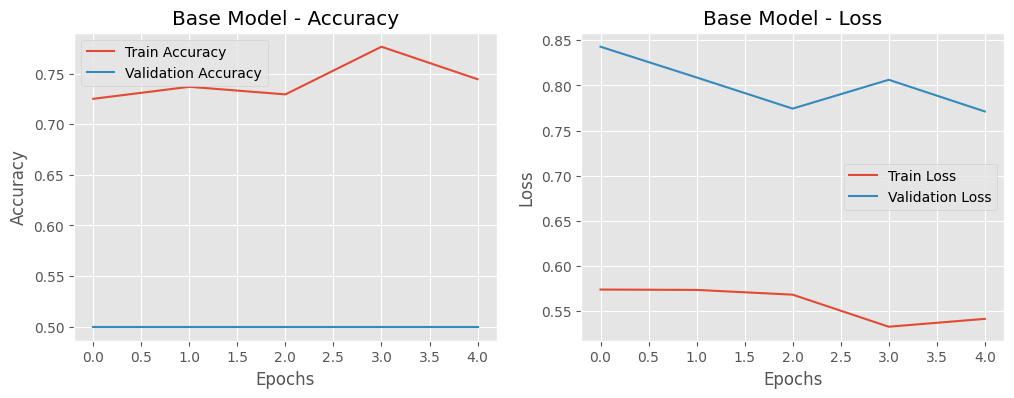

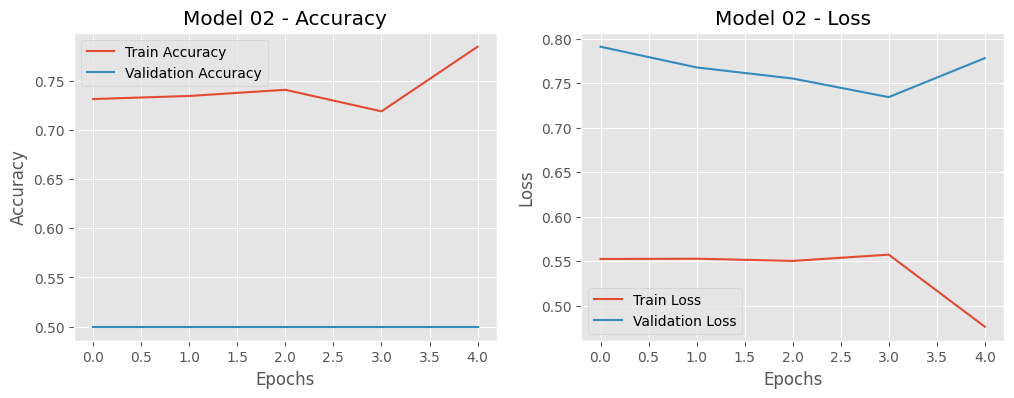

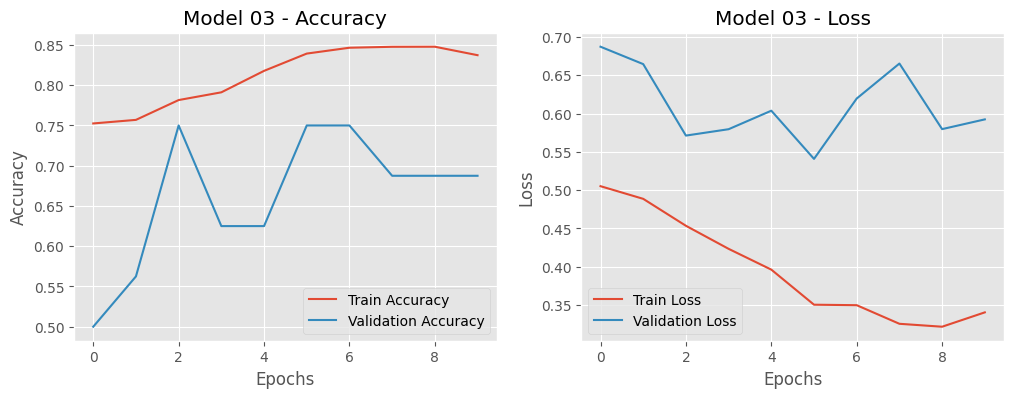

In [35]:
import matplotlib.pyplot as plt

# Load history objects if saved
# history_initial = # load history object for initial model
# history_tuned = # load history object for tuned model
# history_augmented = # load history object for augmented model

def plot_training_history(history, title):
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

# Plot histories
plot_training_history(history_01, 'Base Model')
plot_training_history(history_02, 'Model 02')
plot_training_history(history_03, 'Model 03')
